In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("drive/MyDrive")
image_path = Path("inaturalist/")

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "data.zip", "r") as zip_ref:
    print("unzipping data")
    zip_ref.extractall(image_path)

Did not find inaturalist directory, creating one...
unzipping data


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
!pip install torchinfo
from torchinfo import summary

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [ ]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms=weights.transforms()

In [ ]:
from drive.MyDrive.helpers.data_setup import create_dataloaders
train_dataloader, test_dataloader, class_names=create_dataloaders(train_dir='inaturalist/data/train/',test_dir='inaturalist/data/test/',transform=auto_transforms,batch_size=32,num_workers=os.cpu_count(),)

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model_0=efficientnet_b0(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s]


In [ ]:
summary(model=model_0, input_size=(32,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
for param in model_0.features.parameters():
    param.requires_grad = False

In [ ]:
summary(model=model_0, input_size=(32,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
output_shape=len(class_names)
model_0.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [ ]:
summary(model=model_0, input_size=(32,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 55]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.0001)

In [ ]:
import drive.MyDrive.helpers.engine as engine
import drive.MyDrive.helpers.utils as utils
results=engine.train(model=model_0,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=25,
                     device=device)
utils.save_model(model_0,'trained_model','model_2.pth')

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0408 | train_acc: 0.3651 | test_loss: 2.4093 | test_acc: 0.4942
Epoch: 2 | train_loss: 2.1372 | train_acc: 0.5150 | test_loss: 1.9083 | test_acc: 0.5553
Epoch: 3 | train_loss: 1.8343 | train_acc: 0.5516 | test_loss: 1.6872 | test_acc: 0.5804
Epoch: 4 | train_loss: 1.6856 | train_acc: 0.5739 | test_loss: 1.5933 | test_acc: 0.5862
Epoch: 5 | train_loss: 1.5935 | train_acc: 0.5854 | test_loss: 1.5337 | test_acc: 0.5950
Epoch: 6 | train_loss: 1.5313 | train_acc: 0.5967 | test_loss: 1.4859 | test_acc: 0.5990
Epoch: 7 | train_loss: 1.4845 | train_acc: 0.6039 | test_loss: 1.4839 | test_acc: 0.5957
Epoch: 8 | train_loss: 1.4436 | train_acc: 0.6134 | test_loss: 1.4214 | test_acc: 0.6125
Epoch: 9 | train_loss: 1.4134 | train_acc: 0.6173 | test_loss: 1.4321 | test_acc: 0.6081
Epoch: 10 | train_loss: 1.3927 | train_acc: 0.6219 | test_loss: 1.4341 | test_acc: 0.6019
Epoch: 11 | train_loss: 1.3642 | train_acc: 0.6284 | test_loss: 1.3906 | test_acc: 0.6161
Epoch: 12 | train_l

In [ ]:
print(results)

{'train_loss': [3.0407983833659777, 2.1371535309878262, 1.8343196431506763, 1.6856147462671454, 1.5934892265579916, 1.53130020497062, 1.4844636253010144, 1.4436311901699412, 1.413355386950753, 1.3926655016378924, 1.3642110334309665, 1.3480689927014438, 1.330795394420624, 1.3158132729963823, 1.298723991610787, 1.2873302483992144, 1.2746228935068304, 1.2684306748130105, 1.2558795549219306, 1.2477141872752797, 1.237733006845821, 1.2362081269784406, 1.226030845338648, 1.2152225341363387, 1.2127530166019094], 'train_acc': [0.36513636363636365, 0.5150292207792208, 0.5516298701298702, 0.5738701298701299, 0.5854383116883117, 0.596724025974026, 0.6038668831168832, 0.6133733766233767, 0.6172564935064935, 0.6218993506493506, 0.6283701298701299, 0.6304318181818181, 0.632698051948052, 0.6373961038961039, 0.6425941558441559, 0.644711038961039, 0.6479837662337662, 0.6470454545454546, 0.6508668831168831, 0.6547564935064935, 0.6541006493506494, 0.6546136363636363, 0.6583701298701299, 0.6623766233766234

In [ ]:
len(results)

4

In [ ]:
results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
import matplotlib.pyplot as plt

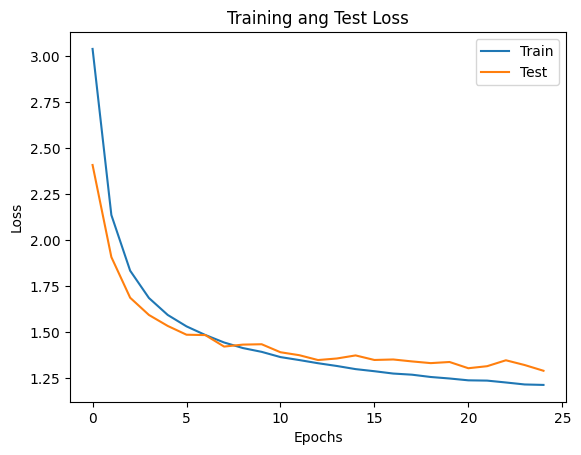

In [ ]:
# For plotting train and test loss
fig,ax=plt.subplots()
ax.set_title('Training ang Test Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.plot(range(len(results['train_loss'])),results['train_loss'],label='Train')
plt.plot(range(len(results['test_loss'])),results['test_loss'],label='Test')
ax.legend()

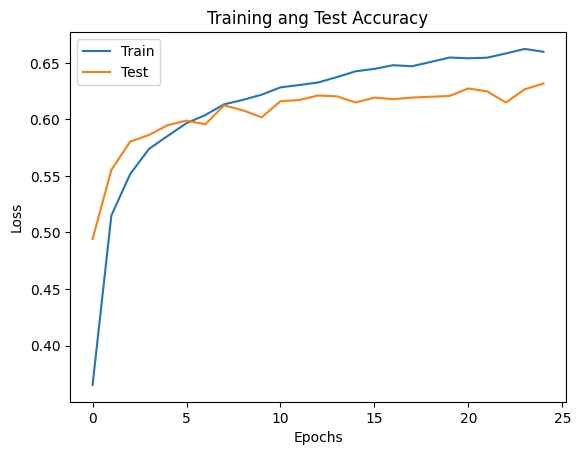

In [ ]:
# For plotting train and test accuracy
fig,ax=plt.subplots()
ax.set_title('Training ang Test Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.plot(range(len(results['train_acc'])),results['train_acc'],label='Train')
plt.plot(range(len(results['test_acc'])),results['test_acc'],label='Test')
ax.legend()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import List, Tuple
def test(model: torch.nn.Module, dataloader,loss_fn: torch.nn.Module, device:torch.device)->Tuple[List[int],List[int]]:
  model.eval()

  y_test, y_pred = [],[]
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device),y.to(device)
      test_pred_logits = model(X)
      y_pred.append(test_pred_logits.tolist())
      y_test.append(y.tolist())
  return y_test, y_pred
y_test,y_pred=test(model=model_0,dataloader=test_dataloader,loss_fn=loss_fn,device=device)
print(len(y_test),len(y_pred))

86 86


In [ ]:
def flatten(list_of_list):
  return [item for row in list_of_list for item in row]